In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import scipy
import pandas as pd
from math import e, log
from scipy import stats
from scipy import integrate
from scipy.optimize import fsolve
from IPython.display import clear_output
import seaborn as sns 

In [2]:
def k_esp (A, E, R, T):
    k = A*e**(-E/(R*T))
    return k

In [3]:
def cp(A, B, C, D, T):
    cap_cal = 8.314*(A + B*T + C*T**2 + D*T**(-2))
    return cap_cal # J/µmol.K

In [4]:
params = [
          2.80987545e-02, # A_SRM [=] mol/s/kg/Pa**a+b 
          2.06007753e+05, # E_SRM [=] J/mol
          8.89015990e-04, # A_WGS [=] mol/s/kg/Pa**2
          1.29419551e+05, # E_WGS [=] J/mol
          2.37901228e+00  # a [=] power law exponent, adimentional
]

In [5]:
R = 8.314 # J/mol.K
P_ref = 1e5 # Pa
viscosity = 3.17e-5 # kg/m/s
def r_SRM(A_SRM, E_SRM, P_CH4, P_H2O, P_CO, P_H2, R, T, P, a, b, eff_SRM):
    k_SRM = k_esp(A_SRM, E_SRM, R, T)
    K_SRM = 5.3e12*e**(-2.61e4/T)
    eta_SRM = ((P_CO*P_H2**3)/(P_CH4*P_H2O*(P_ref**2)*K_SRM))
    r = k_SRM*(P_CH4**a)*(P_H2O**b)*(1-eta_SRM)
    return eff_SRM*r
    
def r_WGS(A_WGS, E_WGS, P_CO, P_H2O, P_CO2, P_H2, R, T, eff_WGS):
    k_WGS = k_esp(A_WGS, E_WGS, R, T)
    K_WGS = (1.45e-2*e**(4.62e3/T))
    k_rWGS = k_WGS/K_WGS
    r = (k_WGS*P_CO*P_H2O
        - k_rWGS*P_CO2*P_H2
        )
    return eff_WGS*r

A_SRM  = params[0]
E_SRM  = params[1]
A_WGS  = params[2]
E_WGS  = params[3]
a = params[4]
b = 0
def odes(W, Y, T_a, D, U, Dp, eff_SRM, eff_WGS):
    F_H2O = Y[0]
    F_CO2 = Y[1]
    F_H2 = Y[2]
    F_N2 = Y[3]
    F_CH4 = Y[4]
    F_CO = Y[5]
    T = Y[6]
    P = Y[7]

    sum_Fj = F_H2O + F_CO2 + F_H2 + F_N2 + F_CH4 + F_CO
    vT = sum_Fj*R*T/P
    
    y_H2O = F_H2O/sum_Fj
    y_CO2 = F_CO2/sum_Fj
    y_H2 = F_H2/sum_Fj
    y_N2 = F_N2/sum_Fj
    y_CH4 = F_CH4/sum_Fj
    y_CO = F_CO/sum_Fj
    
    P_CH4 = P*y_CH4
    P_H2O = P*y_H2O
    P_H2 = P*y_H2
    P_CO = P*y_CO
    P_CO2 = P*y_CO2
    
    rate_WGS = r_WGS(A_WGS, E_WGS, P_CO, P_H2O, P_CO2, P_H2, R, T, eff_WGS)
    rate_DRM = 0
    rate_SRM = r_SRM(A_SRM, E_SRM, P_CH4, P_H2O, P_CO, P_H2, R, T, P, a, b, eff_SRM)

    dF_H2O_dW = - rate_SRM - rate_WGS
    dF_CO2_dW = rate_WGS - rate_DRM
    dF_H2_dW  = 3*rate_SRM + 2*rate_DRM + rate_WGS
    df_N2_dW = 0
    dF_CH4_dW = -rate_SRM - rate_DRM
    dF_CO_dW  = rate_SRM + 2*rate_DRM - rate_WGS

    delta_H_rx_298_SRM = 205813 # J/mol
    delta_H_rx_298_WGS = -41166 # J/mol
    Tr = 298 # K

    f_delta_H_rx_SRM = lambda Temp:(3*cp(3.249, 0.422e-3, 0, 0.083e5, Temp)
                                                    +cp(3.376, 0.557e-3, 0, -0.031e5, Temp)
                                                    -cp(3.47, 1.45e-3, 0, 0.121e5, Temp)
                                                    -cp(1.702, 9.081e-3, -2.164e-6, 0, Temp)
                                                    )
    f_delta_H_rx_WGS = lambda Temp:(cp(3.249, 0.422e-3, 0, 0.083e5, Temp)
                                                     +cp(5.547, 1.045e-3, 0, -1.157e5, Temp)
                                                     -cp(3.376, 0.557e-3, 0, -0.031e5, Temp)
                                                     -cp(3.47, 1.45e-3, 0, 0.121e5, Temp)
                                                    )
    delta_H_rx_SRM, err_delta_H_rx_SRM = integrate.quad(f_delta_H_rx_SRM, Tr, T)
    delta_H_rx_WGS, err_delta_H_rx_WGS = integrate.quad(f_delta_H_rx_WGS, Tr, T)

    delta_H_rx_SRM = (delta_H_rx_298_SRM + delta_H_rx_SRM) # J/mol
    delta_H_rx_WGS = (delta_H_rx_298_WGS + delta_H_rx_WGS) # J/mol

    dT_dW = ((
            (4*U/(bed_packing*(D)))*(T_a - T)
            +(rate_SRM)
            *(-delta_H_rx_SRM)
            +(rate_WGS)
            *(-delta_H_rx_WGS)
            )/
            (F_H2O*cp(3.47, 1.45e-3, 0, 0.121e5, T) # CP [=] J/mol.K
            +F_CO2*cp(5.547, 1.045e-3, 0, -1.157e5, T) # CP [=] J/mol.K
            +F_H2*cp(3.249, 0.422e-3, 0, 0.083e5, T) # # CP [=] J/mol.K
             +F_N2*cp(3.280, 0.593e-3, 0, 0.04e5, T) # # CP [=] J/mol.K
             +F_CH4*cp(1.702, 9.081e-3, -2.164e-6, 0, T) # CP [=] J/mol.K
             +F_CO*cp(3.376, 0.557e-3, 0, -0.031e5, T) # CP [=] J/mol.K
            ))
    gas_density = (((F_H2O*18 + F_CO2*44 + F_CH4*16 + F_N2*28 + F_H2*2 + F_CO*28))/vT)/1000 # kg/m³
    gas_velocity = vT/((np.pi*(D**2)/4)) # m/s
    
    G = gas_density*gas_velocity #kg/m²/s
    dP_dW = -(
        (4/(np.pi*(D**2)*bed_packing))*(G/(gas_density*Dp))*((1-bed_porosity)/(bed_porosity**3))*
        ((150*(1-bed_porosity)*viscosity/Dp) + 1.75*G)
    )/1000 # Pa/kg

    return [dF_H2O_dW, dF_CO2_dW, dF_H2_dW, df_N2_dW, dF_CH4_dW, dF_CO_dW, dT_dW, dP_dW]

In [6]:
n_tubes = 60
F_CH4_in = 0.1276 # mol/s
F_CO2_in = 0.0851 # mol/s
F_H2O_in = 2*F_CH4_in # mol/s
F_CH4_in = F_CH4_in/n_tubes # mol/s
F_CO2_in = F_CO2_in/n_tubes # mol/s
F_H2O_in = F_H2O_in/n_tubes # mol/s
F_N2_e = 0
F_H2_e = 0
F_CO_e = 0
T_C = 800
T_K = T_C + 273
Tfurnace = 800 + 273 # K
D_our = 4.51/100 # m
Dp = 0.4/100 # m
P0 = 5.6e5 # Pa
bed_porosity = (0.9198/((D_our/Dp)**2)) + 0.3414
cat_dens = 2530 # kg/m³
bed_packing = (1-bed_porosity)*cat_dens
Y0 = np.array([F_H2O_in, F_CO2_in, F_H2_e,  F_N2_e, F_CH4_in, F_CO_e, T_K, P0])

mass_cat = 200 # kg
mass_cat = mass_cat/n_tubes # kg

In [7]:
bed_packing

1647.9525324752583

/tmp/ipykernel_7529/2267349326.py:83: RuntimeWarning: invalid value encountered in divide
  H2_CO = F_H2/F_CO


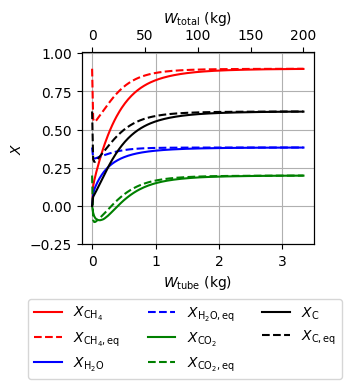

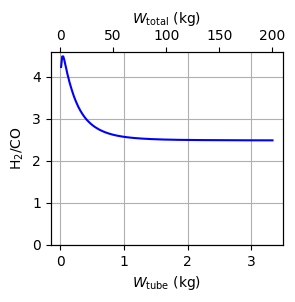

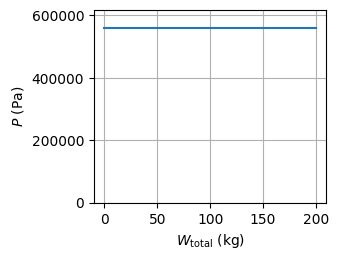

In [8]:
t_span = [0, mass_cat]
steps = 200
W_range = np.linspace(0, mass_cat, num=steps, endpoint=True)
sol = solve_ivp(odes, t_span, Y0, t_eval = W_range,
                args=(T_a:= Tfurnace, D_our, 
                U:=1.161e-4*Tfurnace**2 - 1.9388e-2*Tfurnace + 8.6258,
                Dp, eff_SRM:= 0.03, eff_WGS:= 0.07),
                method = 'BDF'
               )

F_H2O = sol.y[0]
F_CO2 = sol.y[1]
F_H2 = sol.y[2]
F_N2 = sol.y[3]
F_CH4 = sol.y[4]
F_CO = sol.y[5]
T = sol.y[6]
Pressure = sol.y[7]
T_out_C = T - 273

X_CH4 = (F_CH4_in - F_CH4)/F_CH4_in
X_CO2 = (F_CO2_in - F_CO2)/F_CO2_in
X_H2O = (F_H2O_in - F_H2O)/F_H2O_in
# print(X_CH4, X_CO2, X_H2O)

X_CH4 = (F_CH4[0] - F_CH4)/F_CH4[0]
X_H2O = (F_H2O[0] - F_H2O)/F_H2O[0]
X_CO2 = (F_CO2[0] - F_CO2)/F_CO2[0]
X_C = (((F_CH4[0] + F_CO2[0]) - (F_CH4 + F_CO2))/
        (F_CH4[0] + F_CO2[0]))

W_kg = sol.t
W_T_kg = n_tubes*W_kg

### start equilibrium calculation -> using m_cat -> infinity aproach
X_H2O_eq = []
X_CO2_eq = []
X_CH4_eq = []
X_C_eq = []

for i in range(len(X_CH4)):
    mass_cat_eq = 1000
    Y0_eq = [F_H2O[i], F_CO2[i], F_H2[i],  0, F_CH4[i], F_CO[i], T[i], Pressure[i]]
    W_range_eq = np.linspace(1, mass_cat_eq, num=steps, endpoint=True)
    t_span_eq = [0, mass_cat_eq]
    sol_eq = solve_ivp(odes, t_span_eq, Y0_eq,
                args=(T_a:= T[i], D_our, 
                U:=1e6,
                Dp, eff_SRM:= 0.03, eff_WGS:= 0.07),
                method = 'BDF'
               )
    X_CH4_eq.append((F_CH4_in - sol_eq.y[4][-1])/F_CH4_in)
    X_CO2_eq.append((F_CO2_in - sol_eq.y[1][-1])/F_CO2_in)
    X_H2O_eq.append((F_H2O_in - sol_eq.y[0][-1])/F_H2O_in)
    X_C_eq.append(((F_CH4_in + F_CO2_in) - (sol_eq.y[4][-1] + sol_eq.y[1][-1]))/
        (F_CH4_in + F_CO2_in))
### end equilibrium calculation

fig, ax = plt.subplots(figsize=(3,2.5))
plt.grid(which='both')
plt.ylabel('$X$')
plt.ylim((-0.25,1.01))
ax.plot(W_kg, X_CH4, linestyle = 'none')
ax.set_xlabel(r'$W_{\mathrm{tube}}$ (kg)')
ax2 = ax.twiny()
ax2.plot(W_T_kg, X_CH4, color = 'red', label = r'$X_{\mathrm{CH_4}}$')
ax2.plot(W_T_kg, X_CH4_eq, color = 'red', linestyle = 'dashed', label = r'$X_{\mathrm{CH_4, eq}}$')

ax2.plot(W_T_kg, X_H2O, color = 'blue', label = r'$X_{\mathrm{H_2O}}$')
ax2.plot(W_T_kg, X_H2O_eq, color = 'blue', linestyle = 'dashed', label = r'$X_{\mathrm{H_2O, eq}}$')

ax2.plot(W_T_kg, X_CO2, color = 'green', label = r'$X_{\mathrm{CO_2}}$')
ax2.plot(W_T_kg, X_CO2_eq, color = 'green', linestyle = 'dashed', label = r'$X_{\mathrm{CO_2, eq}}$')

ax2.plot(W_T_kg, X_C, color = 'black', label = r'$X_{\mathrm{C}}$')
ax2.plot(W_T_kg, X_C_eq, color = 'black', linestyle = 'dashed', label = r'$X_{\mathrm{C, eq}}$')
plt.legend(bbox_to_anchor=(1.15, -0.25), ncols = 3)
ax2.set_xlabel(r'$W_{\mathrm{total}}$ (kg)')
# plt.xlim(0,max(W_kg)*1.3)
fig_name = 'figure_W_vs_X.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

H2_CO = F_H2/F_CO
fig, ax = plt.subplots(figsize=(3,2.5))
plt.grid(which='both')
plt.ylabel(r'$\mathrm{H_2/CO}$')
ax.plot(W_kg, H2_CO, linestyle = 'none')
ax.set_xlabel(r'$W_{\mathrm{tube}}$ (kg)')
ax2 = ax.twiny()
ax2.plot(W_T_kg, H2_CO, color = 'b')
ax2.set_xlabel(r'$W_{\mathrm{total}}$ (kg)')
plt.ylim(0, None)
fig_name = 'figure_W_vs_H2_CO.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')


W_T_kg_extrinsic = W_T_kg
T_out_C_extrinsic = T_out_C
# fig, axT = plt.subplots(figsize=(3,2.5))
# plt.plot(W_T_kg, T_out_C, label = 'Extrínseco')
# plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
# plt.ylabel('$T$ (ºC)')
# plt.grid(which='both')
# plt.ylim(640,810)
# fig_name = 'figure_W_vs_T.pdf'
# plt.savefig(fig_name, bbox_inches = 'tight')
# plt.savefig(fig_name, bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(W_T_kg, Pressure)
plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
plt.ylabel('$P$ (Pa)')
plt.grid('both')
plt.ticklabel_format(useOffset=False)
plt.ylim(0, Pressure.max()*1.1)

fig_name = 'figure_W_vs_P.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [9]:
z = [4*(W)/(np.pi*((D_our)**2)*bed_packing) for W in W_kg]
i, = np.where(W_T_kg < 80)
z_80kg = z[i[-1]]
z_80kg

np.float64(0.5026493171362371)

In [10]:
X_CH4[i[-1]]

np.float64(0.8585747102464448)

In [11]:
X_CO2[i[-1]]

np.float64(0.17404205946919052)

In [12]:
X_H2O[i[-1]]

np.float64(0.3712506025391645)

In [13]:
H2_CO[i[-1]]

np.float64(2.5236291276726104)

In [14]:
T_out_C[i[-1]]

np.float64(793.0655176001635)

In [15]:
F_CH4[0]*60

np.float64(0.1276)

In [16]:
F_CH4[-1]*60

np.float64(0.013181799670302254)

In [17]:
F_CO[-1]*60

np.float64(0.13130478354230166)

In [18]:
F_H2[-1]*60

np.float64(0.3263680177871496)

In [19]:
X_CH4[-1]

np.float64(0.8966943599506092)

In [20]:
X_CO2[-1]

np.float64(0.19843223517986572)

In [21]:
X_H2O[-1]

np.float64(0.3821771830622508)

In [22]:
H2_CO[-1]

np.float64(2.4855759933681747)

In [23]:
T_out_C[-1]

np.float64(799.8620787517902)

/tmp/ipykernel_7529/573303876.py:86: RuntimeWarning: invalid value encountered in divide
  H2_CO = F_H2/F_CO


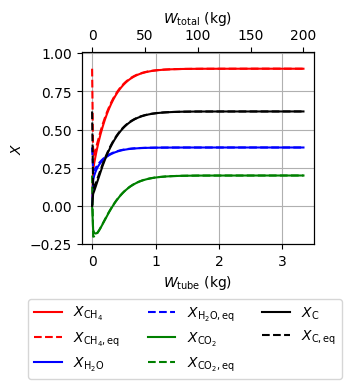

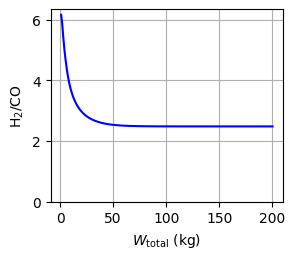

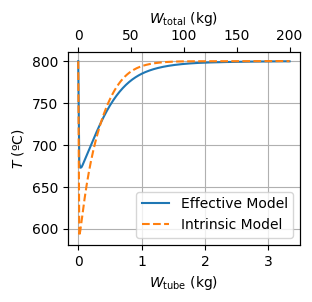

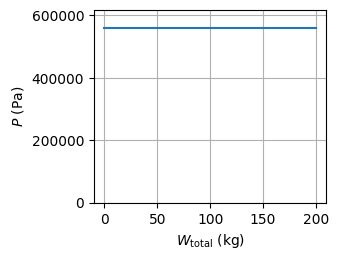

In [24]:
t_span = [0, mass_cat]
steps = 200
W_range = np.linspace(0, mass_cat, num=steps, endpoint=True)
sol = solve_ivp(odes, t_span, Y0, t_eval = W_range,
                args=(T_a:= Tfurnace, D_our, 
                U:=1.161e-4*Tfurnace**2 - 1.9388e-2*Tfurnace + 8.6258,
                Dp, eff_SRM:= 1, eff_WGS:= 1),
                method = 'BDF'
               )

# Fj -> H2O CO2 H2 N2 CH4 CO
F_H2O = sol.y[0]
F_CO2 = sol.y[1]
F_H2 = sol.y[2]
F_N2 = sol.y[3]
F_CH4 = sol.y[4]
F_CO = sol.y[5]
T = sol.y[6]
Pressure = sol.y[7]
T_out_C = T - 273

X_CH4 = (F_CH4_in - F_CH4)/F_CH4_in
X_CO2 = (F_CO2_in - F_CO2)/F_CO2_in
X_H2O = (F_H2O_in - F_H2O)/F_H2O_in
# print(X_CH4, X_CO2, X_H2O)


X_CH4 = (F_CH4[0] - F_CH4)/F_CH4[0]
X_H2O = (F_H2O[0] - F_H2O)/F_H2O[0]
X_CO2 = (F_CO2[0] - F_CO2)/F_CO2[0]
X_C = (((F_CH4[0] + F_CO2[0]) - (F_CH4 + F_CO2))/
        (F_CH4[0] + F_CO2[0]))
# Fj -> H2O CO2 H2 CH4 CO
W_kg = sol.t
W_T_kg = n_tubes*W_kg

### start equilibrium calculation -> using m_cat -> infinity aproach
X_H2O_eq = []
X_CO2_eq = []
X_CH4_eq = []
X_C_eq = []

for i in range(len(X_CH4)):
    mass_cat_eq = 2000
    Y0_eq = [F_H2O[i], F_CO2[i], F_H2[i],  0, F_CH4[i], F_CO[i], T[i], Pressure[i]]
    W_range_eq = np.linspace(1, mass_cat_eq, num=steps, endpoint=True)
    t_span_eq = [0, mass_cat_eq]
    sol_eq = solve_ivp(odes, t_span_eq, Y0_eq,
                args=(T_a:= T[i], D_our, 
                U:=1e6,
                Dp, eff_SRM:= 1, eff_WGS:= 1),
                method = 'BDF'
               )
    X_CH4_eq.append((F_CH4_in - sol_eq.y[4][-1])/F_CH4_in)
    X_CO2_eq.append((F_CO2_in - sol_eq.y[1][-1])/F_CO2_in)
    X_H2O_eq.append((F_H2O_in - sol_eq.y[0][-1])/F_H2O_in)
    X_C_eq.append(((F_CH4_in + F_CO2_in) - (sol_eq.y[4][-1] + sol_eq.y[1][-1]))/
        (F_CH4_in + F_CO2_in))
### end equilibrium calculation

fig, ax = plt.subplots(figsize=(3,2.5))
plt.grid(which='both')
plt.ylabel('$X$')
plt.ylim((-0.25,1.01))
ax.plot(W_kg, X_CH4, linestyle = 'none')
ax.set_xlabel(r'$W_{\mathrm{tube}}$ (kg)')
ax2 = ax.twiny()
ax2.plot(W_T_kg, X_CH4, color = 'red', label = r'$X_{\mathrm{CH_4}}$')
ax2.plot(W_T_kg, X_CH4_eq, color = 'red', linestyle = 'dashed', label = r'$X_{\mathrm{CH_4, eq}}$')

ax2.plot(W_T_kg, X_H2O, color = 'blue', label = r'$X_{\mathrm{H_2O}}$')
ax2.plot(W_T_kg, X_H2O_eq, color = 'blue', linestyle = 'dashed', label = r'$X_{\mathrm{H_2O, eq}}$')

ax2.plot(W_T_kg, X_CO2, color = 'green', label = r'$X_{\mathrm{CO_2}}$')
ax2.plot(W_T_kg, X_CO2_eq, color = 'green', linestyle = 'dashed', label = r'$X_{\mathrm{CO_2, eq}}$')

ax2.plot(W_T_kg, X_C, color = 'black', label = r'$X_{\mathrm{C}}$')
ax2.plot(W_T_kg, X_C_eq, color = 'black', linestyle = 'dashed', label = r'$X_{\mathrm{C, eq}}$')
plt.legend(bbox_to_anchor=(1.15, -0.25), ncols = 3)
ax2.set_xlabel(r'$W_{\mathrm{total}}$ (kg)')
# plt.xlim(0,max(W_kg)*1.3)

fig_name = 'figure_W_vs_X_intrinsic.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

H2_CO = F_H2/F_CO
fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(W_T_kg, H2_CO, color = 'b')
# plt.plot(sol.t, H2_CO_eq, color = 'b', linestyle = 'dashed')
plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
plt.ylabel(r'$\mathrm{H_2/CO}$')
# plt.title(r'$\mathrm{H_2/CO}$')
plt.grid(which='both')
plt.ylim(0,None)
fig_name = 'figure_W_vs_H2_CO_intrinsic.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

fig, axT = plt.subplots(figsize=(3,2.5))
plt.grid(which='both')
plt.ylabel('$T$ (ºC)')
axT.plot(W_kg, T_out_C_extrinsic, linestyle = 'none', label = None)
axT.set_xlabel(r'$W_{\mathrm{tube}}$ (kg)')
axT2 = axT.twiny()
axT2.plot(W_T_kg_extrinsic, T_out_C_extrinsic, label = 'Effective Model')
axT2.plot(W_T_kg, T_out_C, label = 'Intrinsic Model', linestyle = 'dashed')
axT2.set_xlabel(r'$W_{\mathrm{total}}$ (kg)')
axT2.set_ylabel('$T$ (ºC)')

plt.legend(loc="best")
# plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
# plt.ylabel('$T$ (ºC)')
# plt.grid(which='both')
# plt.ylim(640,810)
fig_name = 'figure_W_vs_T.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(W_T_kg, Pressure)
plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
plt.ylabel('$P$ (Pa)')
plt.grid('both')
plt.ticklabel_format(useOffset=False)
plt.ylim(0, Pressure.max()*1.1)

fig_name = 'figure_W_vs_P_intrinsic.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

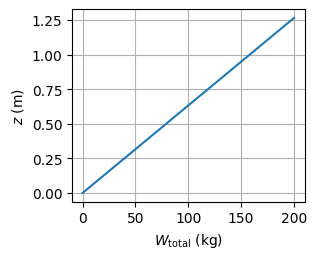

In [25]:
z = [4*(W)/(np.pi*((D_our)**2)*bed_packing) for W in W_kg]
fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(W_T_kg, z)
plt.xlabel(r'$W_{\mathrm{total}}$ (kg)')
plt.ylabel('$z$ (m)')
plt.grid('both')
plt.ticklabel_format(useOffset=False)
fig_name = 'W_vs_z.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [26]:
i, = np.where(W_T_kg < 80)
z_80kg = z[i[-1]]
z_80kg

np.float64(0.5026493171362371)

In [27]:
X_CH4[i[-1]]

np.float64(0.8956400259810008)

In [28]:
X_CO2[i[-1]]

np.float64(0.19622870425199046)

In [29]:
X_H2O[i[-1]]

np.float64(0.38238481419437453)

In [30]:
H2_CO[i[-1]]

np.float64(2.490037725509655)

In [31]:
T_out_C[i[-1]]

np.float64(798.6409302869952)

In [32]:
U_our = 1.161e-4*(800+273)**2 - 1.9388e-2*(800+273) + 8.6258
U_our = int(U_our)
U_our

121

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [136]:
def reactor_simulation(U_list, T_in_C_list, T_furnace_list, H2O_CH4_list, 
                       CH4_CO2_list, D_our_list, n_tubes_list, P0_list, Dp_list,
                       W_T, eff_SRM_list, eff_WGS_list, FT0_list):
    reactor_df = pd.DataFrame()
    for U in U_list:
        for T_in_C in T_in_C_list:
            for T_furnace in T_furnace_list:
                for H2O_CH4 in H2O_CH4_list:
                    for CH4_CO2 in CH4_CO2_list:
                        for D_our in D_our_list: # em cm (1'', 1 1/2'', 2'')
                            for n_tubes in n_tubes_list: # em cm
                                for P0 in P0_list: # em cm
                                    for Dp in Dp_list: # em cm
                                        for eff_SRM in eff_SRM_list:
                                            for eff_WGS in eff_WGS_list:
                                                for FT0 in FT0_list:
                                                    print('U', U, 
                                                          'T_in_C', T_in_C, 
                                                          'T_furnace', T_furnace, 
                                                          'H2O_CH4', H2O_CH4, 
                                                          'CH4_CO2', CH4_CO2, 
                                                          'D_our', D_our, 
                                                          'n_tubes', n_tubes, 
                                                          'P0', P0, 
                                                          'Dp', Dp,
                                                           'W_T', W_T,
                                                           'eff', eff_SRM, eff_WGS,
                                                           'FT0', FT0)
                                                    clear_output(wait=True)
                                                    W = W_T/n_tubes # kg
                                                    t_span = [0, W]
                                                    W_range = np.linspace(0, W, num=2000, endpoint=False)
                                                    F_CH4_in = 0.6*FT0 # mol/s
                                                    F_CH4_in = F_CH4_in/n_tubes # µmol/s
                                                    F_H2O_in = F_CH4_in*H2O_CH4
                                                    F_CO2_in = F_CH4_in/CH4_CO2
                                                    Y0 = [F_H2O_in, F_CO2_in, F_H2_e, F_N2_e, F_CH4_in, F_CO_e, T_in_C+273, P0]
                                                    sol = solve_ivp(odes, t_span, Y0, t_eval = W_range,
                                                                    args=(T_a:= T_furnace + 273, D_our/100, # D em m
                                                                    U, Dp/100, eff_SRM, eff_WGS), # Dp em m
                                                                    method = 'BDF'
                                                                   )
                                                    temp_df = pd.DataFrame(np.transpose(sol.y), 
                                                                                          columns = ('F_H2O', 
                                                                                                     'F_CO2', 
                                                                                                     'F_H2', 
                                                                                                     'F_N2', 
                                                                                                     'F_CH4', 
                                                                                                     'F_CO', 
                                                                                                     '$T$ (K)', '$P$ (Pa)'))
                                                    temp_df[r'$F_{\mathrm{biogas_0}}$ (mol/s)'] = FT0
                                                    temp_df['biogas feed (kg/day)'] = FT0*3600*24*27.2/1000
                                                    temp_df['$\dot{m}_{C_{12}H_{26}}$ (kg/dia)'] = 0.5*temp_df['F_CO']*n_tubes*170*86400/(12*1000)
                                                    temp_df[r'$\eta_{\mathrm{SRM}}$'] = eff_SRM
                                                    y_CH4 = temp_df['F_CH4']/(
                                                    temp_df['F_H2O'] + temp_df['F_CO2'] + temp_df['F_H2'] +
                                                    temp_df['F_N2'] + temp_df['F_CH4'] + temp_df['F_CO']
                                                    )
                                                    temp_df['$P_{CH_4}$ (Pa)'] = temp_df['$P$ (Pa)']*y_CH4
                                                    temp_df[r'$\eta_{\mathrm{WGS}}$'] = eff_WGS
                                                    temp_df[r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)'] = U
                                                    temp_df[r'$T_{\mathrm{in}}$ (ºC)'] = T_in_C
                                                    temp_df['$T$ (ºC)'] = temp_df['$T$ (K)'] - 273
                                                    temp_df[r'$T_{\mathrm{furnace}}$ (ºC)'] = T_furnace
                                                    temp_df[r'$W_{\mathrm{tube}}$ (kg)'] = sol.t
                                                    temp_df[r'$W_{\mathrm{total}}$ (kg)'] = sol.t*n_tubes
                                                    temp_df['$\Delta T_{max}$ (K)'] = temp_df['$T$ (K)'].max() - temp_df['$T$ (K)'].min()
                                                    temp_df['$T_{min}$ (ºC)'] = temp_df['$T$ (ºC)'].min()
                                                    temp_df[r'$\mathrm{H_2O/CH_4}$'] = H2O_CH4
                                                    temp_df[r'$\mathrm{CH_4/CO_2}$'] = CH4_CO2
                                                    temp_df['$D$ (cm)'] = D_our
                                                    temp_df['$D_p$ (cm)'] = Dp
                                                    temp_df['$D_p$ (mm)'] = Dp*10
                                                    temp_df['$P_0$ (bar)'] = P0/1e5
                                                    temp_df['$\Delta P$ (Pa)'] = temp_df['$P$ (Pa)'].iloc[0] - temp_df['$P$ (Pa)'].iloc[-1]
                                                    temp_df['$n_{tubes}$'] = n_tubes
                                                    temp_df['$z$ (m)'] = 4*(sol.t[-1])/(np.pi*((D_our/100)**2)*bed_packing)
                                                    temp_df[r'$\mathrm{H_2/CO}$'] = temp_df['F_H2']/temp_df['F_CO']
                                                    temp_df[r'$\mathrm{(H_2/CO)_{out}}$'] = temp_df[r'$\mathrm{H_2/CO}$'].iloc[-1]
                                                    temp_df[r'$X_{\mathrm{CH_4}}$'] = (F_CH4_in - temp_df['F_CH4'])/F_CH4_in
                                                    temp_df[r'$X_{\mathrm{H_2O}}$'] = (F_H2O_in - temp_df['F_H2O'])/F_H2O_in
                                                    temp_df[r'$X_{\mathrm{CO_2}}$'] = (F_CO2_in - temp_df['F_CO2'])/F_CO2_in
                                                    temp_df[r'$X_{\mathrm{CH_4,out}}$'] = temp_df[r'$X_{\mathrm{CH_4}}$'].iloc[-1]
                                                    temp_df[r'$X_{\mathrm{H_2O,out}}$'] = temp_df[r'$X_{\mathrm{H_2O}}$'].iloc[-1]
                                                    temp_df[r'$X_{\mathrm{CO_2,out}}$'] = temp_df[r'$X_{\mathrm{CO_2}}$'].iloc[-1]
                                                    temp_df[r'$X_\mathrm{C}$'] = ((F_CH4_in + F_CO2_in) - (temp_df['F_CH4'] + temp_df['F_CO2']))/(F_CH4_in + F_CO2_in)
                                                    temp_df[r'$X_{\mathrm{C,out}}$'] = temp_df[r'$X_\mathrm{C}$'].iloc[-1]
                                                    temp_df[r'$Y_\mathrm{H_2}$'] = temp_df['F_H2']/(F_CH4_in - temp_df['F_CH4'])
                                                    temp_df[r'$Y_\mathrm{CO_2}$'] = (temp_df['F_CO2'] - F_CO2_in)/(F_CH4_in - temp_df['F_CH4'])
                                                    temp_df[r'$Y_\mathrm{CO}$'] = (temp_df['F_CO'])/(F_CH4_in - temp_df['F_CH4'])
                                                    temp_df[r'$Y_\mathrm{H_2,~out}$'] = temp_df[r'$Y_\mathrm{H_2}$'].iloc[-1]
                                                    temp_df[r'$Y_\mathrm{CO_2,~out}$'] = temp_df[r'$Y_\mathrm{CO_2}$'].iloc[-1]
                                                    temp_df[r'$Y_\mathrm{CO,~out}$'] = temp_df[r'$Y_\mathrm{CO}$'].iloc[-1]
                                                    temp_df['Mears criterion'] = (k_esp (A_SRM, E_SRM, R, temp_df['$T$ (K)'])*temp_df['$P_{CH_4}$ (Pa)']**a*
                                                                                  bed_packing*R*temp_df['$T$ (K)']*(Dp/100)*a
                                                    )/(2*0.273*temp_df['$P_{CH_4}$ (Pa)'])
                                                    reactor_df = pd.concat([reactor_df, temp_df], ignore_index=True)
    return(reactor_df)

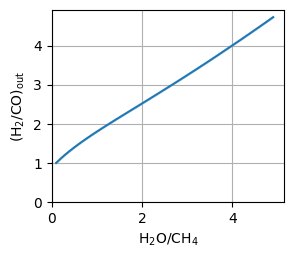

In [35]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = np.arange(0.1, 5, 0.1)
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
eff_WGS = [0.07]
mass_cat = 80 # kg
FT0 = [0.2128] # mol/s
reactor_df_H2_CO_80kg = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, 
                                           CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$\mathrm{H_2O/CH_4}$', y=r'$\mathrm{(H_2/CO)_{out}}$',
             data=reactor_df_H2_CO_80kg, ax = ax)
# 
fig_name = 'figure_H2O_CH4_vs_H2_CO_80kg.pdf'
plt.ylabel(r'$\mathrm{(H_2/CO)_{out}}$')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(which='both')
plt.savefig(fig_name, bbox_inches = 'tight')

In [36]:
reactor_df_H2_CO_80kg.iloc[(reactor_df_H2_CO_80kg[r'$\mathrm{(H_2/CO)_{out}}$']-2).abs().argsort()[:1]][r'$\mathrm{H_2O/CH_4}$']

24047    1.3
Name: $\mathrm{H_2O/CH_4}$, dtype: float64

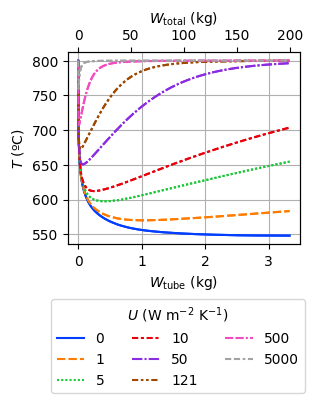

In [37]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [0, 1, 5, 10, 50, 121, 500, 5000]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200 # kg
reactor_df_U = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y='$T$ (ºC)', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', ax = ax)
# 
fig_name = 'figure_W_vs_T_hue_U.pdf'
plt.grid(which='both')
plt.legend(title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25), ncols = 3)
ax2 = ax.twiny()
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y='$T$ (ºC)', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', ax = ax2, legend = None, linestyle = None)
# plt.title('(a)')
plt.savefig(fig_name, bbox_inches = 'tight')

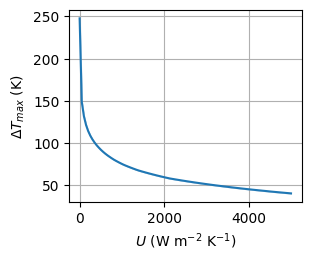

In [38]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = np.linspace(0.1, 5000, num = 100)
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
reactor_df = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', y='$\Delta T_{max}$ (K)',
             data=reactor_df)
# 
fig_name = 'figure_U_vs_DTmax.pdf'
plt.grid(which='both')
# plt.title('(b)')
# plt.yscale('log')
plt.savefig(fig_name, bbox_inches = 'tight')

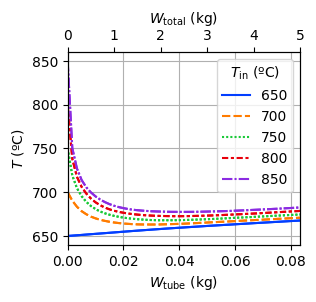

In [39]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [650, 700, 750, 800, 850]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
reactor_df_T_in = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y='$T$ (ºC)', hue=r'$T_{\mathrm{in}}$ (ºC)', 
             data=reactor_df_T_in, 
                palette = 'bright',
                style=r'$T_{\mathrm{in}}$ (ºC)', ax = ax)
plt.grid(which='both')
ax2 = ax.twiny()
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y='$T$ (ºC)', hue=r'$T_{\mathrm{in}}$ (ºC)', 
             data=reactor_df_T_in, 
                palette = 'bright',
                style=r'$T_{\mathrm{in}}$ (ºC)', ax = ax2, legend = None, linestyle = None)
ax.set_xlim(0, (200/60)/40)
ax2.set_xlim(0, (200)/40)
fig_name = 'figure_W_vs_T_hue_T_in.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [40]:
reactor_df_T_in.loc[
    reactor_df_T_in[r'$T_{\mathrm{in}}$ (ºC)'] == 850]['$T_{min}$ (ºC)']

8000    677.52003
8001    677.52003
8002    677.52003
8003    677.52003
8004    677.52003
          ...    
9995    677.52003
9996    677.52003
9997    677.52003
9998    677.52003
9999    677.52003
Name: $T_{min}$ (ºC), Length: 2000, dtype: float64

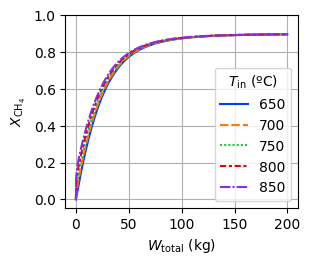

In [41]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$', hue=r'$T_{\mathrm{in}}$ (ºC)', 
             data=reactor_df_T_in, 
                palette = 'bright',
                style=r'$T_{\mathrm{in}}$ (ºC)')
# plt.xlim(0,10)
plt.ylim(None, 1)
plt.grid(which='both')
fig_name = 'figure_W_vs_XCH4_hue_T_in.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [42]:
U = [0, 10, 50, 121, 200, 500, 5000]
T_in_C = np.arange(700, 1010, 10)
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 80
reactor_df_U_T_in = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 5000 T_in_C 1000 T_furnace 800 H2O_CH4 2 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 560000.0 Dp 0.4 W_T 80 eff 0.03 0.07 FT0 0.2128


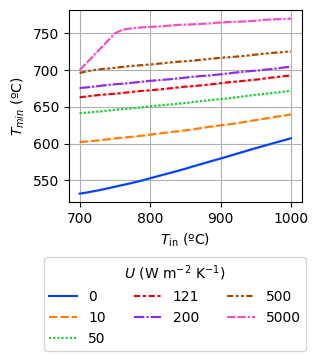

In [43]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$T_{\mathrm{in}}$ (ºC)', y='$T_{min}$ (ºC)', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U_T_in, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.legend(ncols = 2, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_T_in_vs_T_min_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [44]:
reactor_df_U_T_in.loc[
    reactor_df_U_T_in[r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)'] == 500].loc[
    reactor_df_U_T_in[r'$T_{\mathrm{in}}$ (ºC)'] == 800]['$T_{min}$ (ºC)']

330000    707.636764
330001    707.636764
330002    707.636764
330003    707.636764
330004    707.636764
             ...    
331995    707.636764
331996    707.636764
331997    707.636764
331998    707.636764
331999    707.636764
Name: $T_{min}$ (ºC), Length: 2000, dtype: float64

In [45]:
800 - reactor_df_U_T_in.loc[
    reactor_df_U_T_in[r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)'] == 121].loc[
    reactor_df_U_T_in[r'$T_{\mathrm{in}}$ (ºC)'] == 800]['$T_{min}$ (ºC)']

206000    127.390176
206001    127.390176
206002    127.390176
206003    127.390176
206004    127.390176
             ...    
207995    127.390176
207996    127.390176
207997    127.390176
207998    127.390176
207999    127.390176
Name: $T_{min}$ (ºC), Length: 2000, dtype: float64

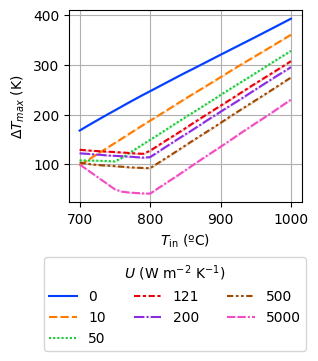

In [46]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$T_{\mathrm{in}}$ (ºC)', y='$\Delta T_{max}$ (K)', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U_T_in, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.legend(ncols = 1, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_T_in_vs_DTmax_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [47]:
U = [0, 10, 20, 50, 121, 500]
T_in_C = [700]
T_furnace = np.arange(650, 860, 10)
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200
FT0 = [0.2128] # mol/s
reactor_df_U_T_furnace = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 500 T_in_C 700 T_furnace 850 H2O_CH4 2 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 560000.0 Dp 0.4 W_T 200 eff 0.03 0.07 FT0 0.2128


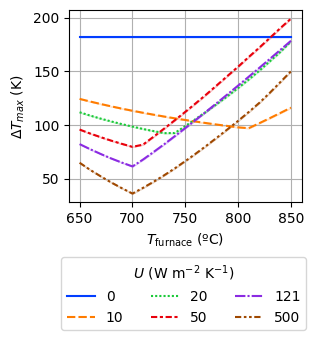

In [48]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$T_{\mathrm{furnace}}$ (ºC)', y='$\Delta T_{max}$ (K)', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U_T_furnace, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
plt.grid(which='both')
fig_name = 'figure_Tfurnace_vs_DTmax_hue_U.pdf'
plt.savefig(fig_name, 
            bbox_inches = 'tight')

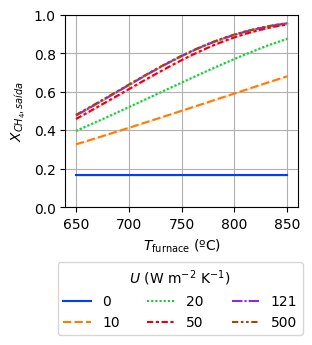

In [49]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$T_{\mathrm{furnace}}$ (ºC)', y=r'$X_{\mathrm{CH_4,out}}$', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U_T_furnace, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
plt.grid(which='both')
plt.ylabel('$X_{CH_4,saída}$')
plt.ylim(0, 1)
plt.xlabel(r'$T_{\mathrm{furnace}}$ (ºC)')
fig_name = 'figure_Tfurnace_vs_X_CH4_hue_U.pdf'
plt.savefig(fig_name, 
            bbox_inches = 'tight')

In [50]:
U = [50]
T_in_C = [700]
T_furnace = [650, 700, 750, 800, 850]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.5e5]
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200
reactor_df_Tfurnace_U50 = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 50 T_in_C 700 T_furnace 850 H2O_CH4 2 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 550000.0 Dp 0.4 W_T 200 eff 0.03 0.07 FT0 0.2128


In [51]:
reactor_df_Tfurnace_U50.columns

Index(['F_H2O_s', 'F_CO2_s', 'F_H2_s', 'F_N2_s', 'F_CH4_s', 'F_CO_s',
       '$T$ (K)', '$P$ (Pa)', '$F_{\mathrm{biogas_0}}$ (mol/s)',
       'biogas feed (kg/day)', '$\dot{m}_{C_{12}H_{26}}$ (kg/dia)',
       '$\eta_{\mathrm{SRM}}$', '$P_{CH_4}$ (Pa)', '$\eta_{\mathrm{WGS}}$',
       '$U~(\mathrm{W~m^{-2}~K^{-1}}$)', '$T_{\mathrm{in}}$ (ºC)', '$T$ (ºC)',
       '$T_{\mathrm{furnace}}$ (ºC)', '$W_{\mathrm{tube}}$ (kg)',
       '$W_{\mathrm{total}}$ (kg)', '$\Delta T_{max}$ (K)', '$T_{min}$ (ºC)',
       '$\mathrm{H_2O/CH_4}$', '$\mathrm{CH_4/CO_2}$', '$D$ (cm)',
       '$D_p$ (cm)', '$D_p$ (mm)', '$P_0$ (bar)', '$\Delta P$ (Pa)',
       '$n_{tubes}$', '$z$ (m)', '$\mathrm{H_2/CO}$',
       '$\mathrm{(H_2/CO)_{out}}$', '$X_{\mathrm{CH_4}}$',
       '$X_{\mathrm{H_2O}}$', '$X_{\mathrm{CO_2}}$', '$X_{\mathrm{CH_4,out}}$',
       '$X_{\mathrm{H_2O,out}}$', '$X_{\mathrm{CO_2,out}}$', '$X_\mathrm{C}$',
       '$X_{\mathrm{C,out}}$', 'Mears criterion'],
      dtype='object')

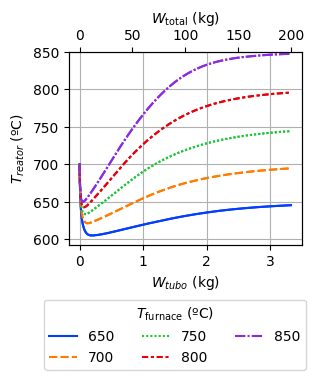

In [52]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y='$T$ (ºC)', hue=r'$T_{\mathrm{furnace}}$ (ºC)', 
             data=reactor_df_Tfurnace_U50, 
                palette = 'bright',
                style=r'$T_{\mathrm{furnace}}$ (ºC)', ax = ax)
plt.grid(which='both')
plt.ylim(None, 850)
plt.xlabel('$W_{tubo}$ (kg)')
plt.ylabel('$T_{reator}$ (ºC)')
plt.legend(ncols = 3, title = r'$T_{\mathrm{furnace}}$ (ºC)', bbox_to_anchor=(1.05, -0.25))
ax2 = ax.twiny()
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y='$T$ (ºC)', hue=r'$T_{\mathrm{furnace}}$ (ºC)', 
             data=reactor_df_Tfurnace_U50, 
                palette = 'bright',
                style=r'$T_{\mathrm{furnace}}$ (ºC)', ax = ax2, legend = None, linestyle = None)
fig_name = 'figure_W_vs_T_hue_Tfurnace.pdf'
plt.savefig(fig_name, 
            bbox_inches = 'tight')

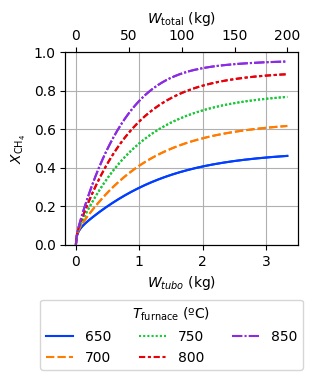

In [53]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$', hue=r'$T_{\mathrm{furnace}}$ (ºC)', 
             data=reactor_df_Tfurnace_U50, 
                palette = 'bright',
                style=r'$T_{\mathrm{furnace}}$ (ºC)', ax = ax)
plt.grid(which='both')
plt.xlabel('$W_{tubo}$ (kg)')
plt.ylim(0,1)
plt.legend(ncols = 3, title = r'$T_{\mathrm{furnace}}$ (ºC)', bbox_to_anchor=(1.05, -0.25))
ax2 = ax.twiny()
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$', hue=r'$T_{\mathrm{furnace}}$ (ºC)', 
             data=reactor_df_Tfurnace_U50, 
                palette = 'bright',
                style=r'$T_{\mathrm{furnace}}$ (ºC)', ax = ax2, legend = None, linestyle = None)
fig_name = 'figure_W_vs_X_CH4_hue_Tfurnace.pdf'
plt.savefig(fig_name, 
            bbox_inches = 'tight')

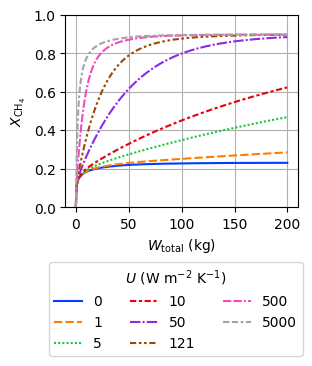

In [54]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.ylim(0,1)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_XCH4_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

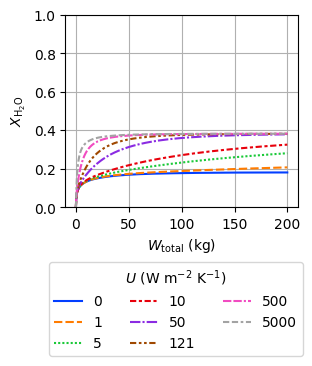

In [55]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{H_2O}}$', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.ylim(0,1)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_XH2O_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

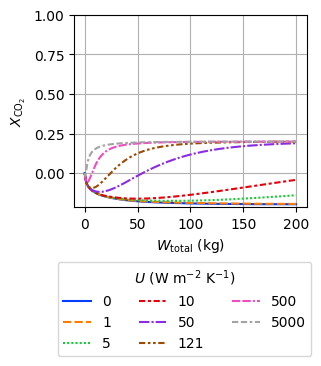

In [56]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CO_2}}$', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.ylim(None,1)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_XCO2_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

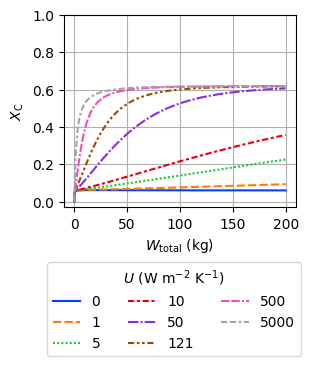

In [57]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_\mathrm{C}$', hue=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', 
             data=reactor_df_U, 
                palette = 'bright',
                style=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)')
plt.ylim(None,1)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_XC_hue_U.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [153]:
U = [121]
T_in_C = [800]
T_furnace = [800]
# H2O_CH4 = [0.1, 1, 2, 4, 6, 10]
H2O_CH4 = np.linspace(0.1, 10, num = 100)
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 80
reactor_df_H2O_CH4 = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
# fig, ax = plt.subplots(figsize=(3,2.5))
# sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y=r'$X_\mathrm{C}$', hue=r'$\mathrm{H_2O/CH_4}$', 
#              data=reactor_df_H2O_CH4, 
#                 palette = 'bright',
#                 style=r'$\mathrm{H_2O/CH_4}$', ax = ax)
# plt.ylim(None,1)
# plt.grid(which='both')
# plt.legend(ncols = 3, title = r'$\mathrm{H_2O/CH_4}$', bbox_to_anchor=(1.05, -0.25))
# ax2 = ax.twiny()
# sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_\mathrm{C}$', hue=r'$\mathrm{H_2O/CH_4}$', 
#              data=reactor_df_H2O_CH4, 
#                 palette = 'bright',
#                 style=r'$\mathrm{H_2O/CH_4}$', ax = ax2, legend = None, linestyle = None)
# fig_name = 'figure_W_vs_XC_hue_H2O_CH4.pdf'
# plt.savefig(fig_name, bbox_inches = 'tight')

U 121 T_in_C 800 T_furnace 800 H2O_CH4 10.0 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 560000.0 Dp 0.4 W_T 80 eff 0.03 1 FT0 0.2128


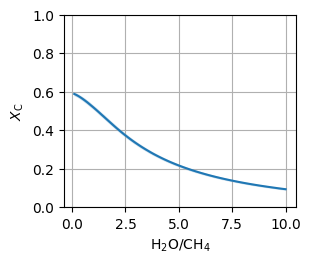

In [154]:
fig, ax = plt.subplots(figsize=(3,2.5))

sns.lineplot(x=r'$\mathrm{H_2O/CH_4}$', y=r'$X_\mathrm{C}$',
             data=reactor_df_H2O_CH4, ax = ax)
plt.ylim(0,1)
plt.grid(which='both')
# plt.legend(ncols = 3, title = r'$\mathrm{H_2O/CH_4}$', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_H2O_CH4_vs_XC.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

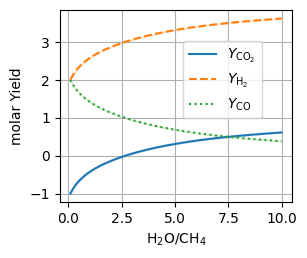

In [155]:
fig, ax = plt.subplots(figsize=(3,2.5))

sns.lineplot(x=r'$\mathrm{H_2O/CH_4}$', y=r'$Y_\mathrm{CO_2,~out}$', 
             data=reactor_df_H2O_CH4, ax = ax, label = r'$Y_\mathrm{CO_2}$')
sns.lineplot(x=r'$\mathrm{H_2O/CH_4}$', y=r'$Y_\mathrm{H_2,~out}$', 
             data=reactor_df_H2O_CH4, ax = ax,  label = r'$Y_\mathrm{H_2}$', linestyle='dashed')
sns.lineplot(x=r'$\mathrm{H_2O/CH_4}$', y=r'$Y_\mathrm{CO,~out}$', 
             data=reactor_df_H2O_CH4, ax = ax,  label = r'$Y_\mathrm{CO}$', linestyle='dotted')
# plt.ylim(None,1)
plt.grid(which='both')
plt.ylabel('molar Yield')
plt.legend(
    bbox_to_anchor=(0.5, 0.4)
)
fig_name = 'figure_H2O_CH4_vs_Y.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

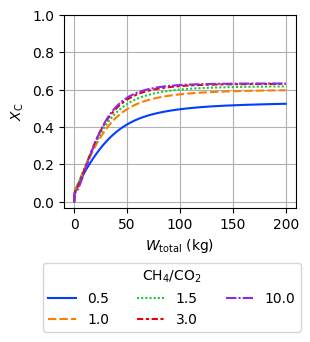

In [59]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [0.5, 1, 1.5, 3, 10]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200
reactor_df_CH4_CO2 = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_\mathrm{C}$', hue=r'$\mathrm{CH_4/CO_2}$', 
             data=reactor_df_CH4_CO2, 
                palette = 'bright',
                style=r'$\mathrm{CH_4/CO_2}$')
plt.ylim(None,1)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$\mathrm{CH_4/CO_2}$', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_XC_hue_CH4_CO2.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

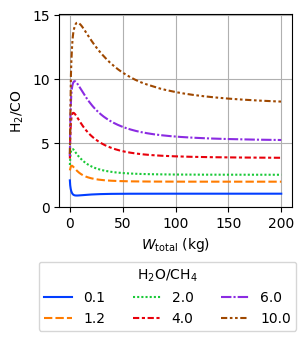

In [60]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$\mathrm{H_2/CO}$', hue=r'$\mathrm{H_2O/CH_4}$', 
             data=reactor_df_H2O_CH4, 
                palette = 'bright',
                style=r'$\mathrm{H_2O/CH_4}$')
plt.ylim(0,None)
plt.grid(which='both')
plt.legend(ncols = 3, title = r'$\mathrm{H_2O/CH_4}$', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_H2_CO_hue_H2O_CH4.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

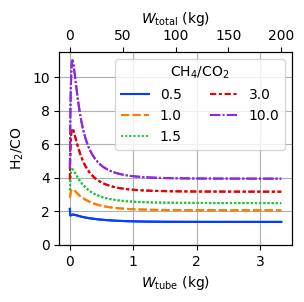

In [61]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{tube}}$ (kg)', y=r'$\mathrm{H_2/CO}$', hue=r'$\mathrm{CH_4/CO_2}$', 
             data=reactor_df_CH4_CO2, 
                palette = 'bright',
                style=r'$\mathrm{CH_4/CO_2}$', ax = ax)
plt.ylim(0,None)
plt.grid(which='both')
plt.legend(ncols = 2, title = r'$\mathrm{CH_4/CO_2}$')
ax2 = ax.twiny()
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$\mathrm{H_2/CO}$', hue=r'$\mathrm{CH_4/CO_2}$', 
             data=reactor_df_CH4_CO2, 
                palette = 'bright',
                style=r'$\mathrm{CH_4/CO_2}$', ax = ax2, legend = None, linestyle = None)
fig_name = 'figure_W_vs_H2_CO_hue_CH4_CO2.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

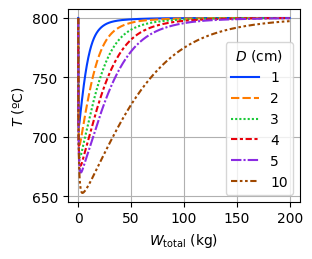

In [62]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
one_inch = 2.54 # cm
D_our = [1, 2, 3, 4, 5, 10]
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200
reactor_df_D = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y='$T$ (ºC)', hue='$D$ (cm)', 
             data=reactor_df_D, 
                palette = 'bright',
                style='$D$ (cm)')
plt.grid(which='both')
fig_name = 'figure_W_vs_T_hue_D.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

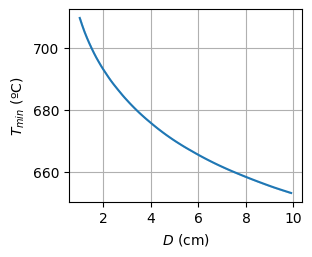

In [63]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
one_inch = 2.54 # cm
D_our = np.arange(1, 10, 0.1)
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
reactor_df_D = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x='$D$ (cm)', y='$T_{min}$ (ºC)',
             data=reactor_df_D)
plt.grid(which='both')
fig_name = 'figure_D_vs_Tmin.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

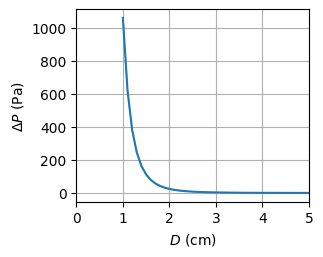

In [64]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x='$D$ (cm)', y='$\Delta P$ (Pa)',
             data=reactor_df_D)
plt.grid(which='both')
plt.ticklabel_format(useOffset=False)
plt.xlim(0, 5)
# plt.yscale('log')
fig_name = 'figure_D_vs_DeltaP.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

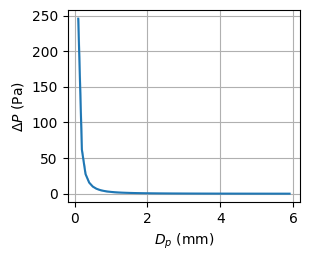

In [65]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
eff_SRM = [0.03]
Dp = np.arange(0.01, 0.6, 0.01)
mass_cat = 80
reactor_df_Dp = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x='$D_p$ (mm)', y='$\Delta P$ (Pa)',
             data=reactor_df_Dp)
plt.grid(which='both')

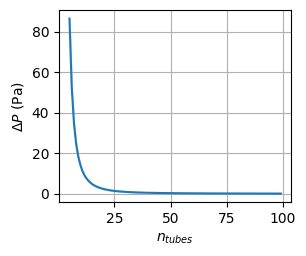

In [66]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = np.arange(5, 100, 1)
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.03]
reactor_df_n_tubes = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x='$n_{tubes}$', y='$\Delta P$ (Pa)',
             data=reactor_df_n_tubes)
plt.grid(which='both')
# plt.yscale('log')

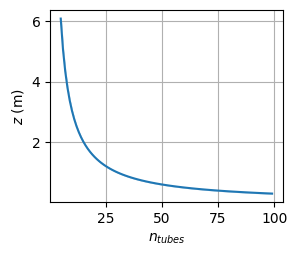

In [67]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x='$n_{tubes}$', y='$z$ (m)',
             data=reactor_df_n_tubes)
plt.grid(which='both')

In [68]:
reactor_df_Dp.columns

Index(['F_H2O_s', 'F_CO2_s', 'F_H2_s', 'F_N2_s', 'F_CH4_s', 'F_CO_s',
       '$T$ (K)', '$P$ (Pa)', '$F_{\mathrm{biogas_0}}$ (mol/s)',
       'biogas feed (kg/day)', '$\dot{m}_{C_{12}H_{26}}$ (kg/dia)',
       '$\eta_{\mathrm{SRM}}$', '$P_{CH_4}$ (Pa)', '$\eta_{\mathrm{WGS}}$',
       '$U~(\mathrm{W~m^{-2}~K^{-1}}$)', '$T_{\mathrm{in}}$ (ºC)', '$T$ (ºC)',
       '$T_{\mathrm{furnace}}$ (ºC)', '$W_{\mathrm{tube}}$ (kg)',
       '$W_{\mathrm{total}}$ (kg)', '$\Delta T_{max}$ (K)', '$T_{min}$ (ºC)',
       '$\mathrm{H_2O/CH_4}$', '$\mathrm{CH_4/CO_2}$', '$D$ (cm)',
       '$D_p$ (cm)', '$D_p$ (mm)', '$P_0$ (bar)', '$\Delta P$ (Pa)',
       '$n_{tubes}$', '$z$ (m)', '$\mathrm{H_2/CO}$',
       '$\mathrm{(H_2/CO)_{out}}$', '$X_{\mathrm{CH_4}}$',
       '$X_{\mathrm{H_2O}}$', '$X_{\mathrm{CO_2}}$', '$X_{\mathrm{CH_4,out}}$',
       '$X_{\mathrm{H_2O,out}}$', '$X_{\mathrm{CO_2,out}}$', '$X_\mathrm{C}$',
       '$X_{\mathrm{C,out}}$', 'Mears criterion'],
      dtype='object')

In [69]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = np.arange(1e4, 2.01e6, 1e4)
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 80
reactor_df_P0_effect = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 121 T_in_C 800 T_furnace 800 H2O_CH4 2 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 2000000.0 Dp 0.4 W_T 80 eff 0.03 0.07 FT0 0.2128


In [70]:
P_otima = reactor_df_P0_effect['$P_0$ (bar)'].loc[reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'] == 
                                        reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].max()].mean()
P_otima

np.float64(5.599999999999999)

In [71]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 1].mean()

np.float64(0.4153532085263815)

In [72]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 4].mean()

np.float64(0.8321856263881013)

In [73]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 6].mean()

np.float64(0.8576130038814467)

In [74]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 5.6].mean()

np.float64(0.8589566990601972)

In [75]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 10].mean()

np.float64(0.7887789198335414)

In [76]:
reactor_df_P0_effect[r'$X_{\mathrm{CH_4,out}}$'].loc[reactor_df_P0_effect['$P_0$ (bar)'] == 20].mean()

np.float64(0.6377198411702361)

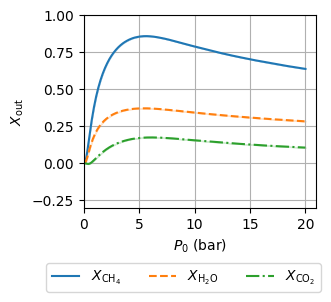

In [77]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_P0_effect, label = r'$X_{\mathrm{CH_4}}$', ax = ax)
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{H_2O,out}}$',
             data=reactor_df_P0_effect, label = r'$X_{\mathrm{H_2O}}$', ax = ax, linestyle='dashed')
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{CO_2,out}}$',
             data=reactor_df_P0_effect, label = r'$X_{\mathrm{CO_2}}$', ax = ax, linestyle='dashdot')
plt.xlim(0,None)
plt.ylim(None,1)
plt.grid(which='both')
plt.ylabel(r'$X_{\mathrm{out}}$')
plt.legend(ncols = 3, bbox_to_anchor=(1.05, -0.25))
plt.ylim(-0.3,1)
fig_name = 'figure_P0_vs_X_CH4.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

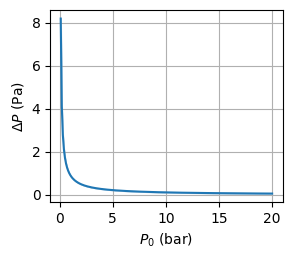

In [78]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x='$P_0$ (bar)', y='$\Delta P$ (Pa)',
             data=reactor_df_P0_effect)
plt.grid(which='both')

In [79]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [4]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = np.arange(1e4, 2.01e6, 1e4)
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 80
reactor_df_P0_effect_H2_prod = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 121 T_in_C 800 T_furnace 800 H2O_CH4 4 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 2000000.0 Dp 0.4 W_T 80 eff 0.03 0.07 FT0 0.2128


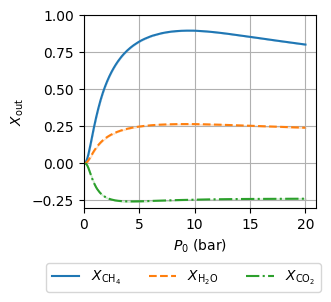

In [80]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_P0_effect_H2_prod, label = r'$X_{\mathrm{CH_4}}$', ax = ax)
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{H_2O,out}}$',
             data=reactor_df_P0_effect_H2_prod, label = r'$X_{\mathrm{H_2O}}$', ax = ax, linestyle='dashed')
sns.lineplot(x='$P_0$ (bar)', y=r'$X_{\mathrm{CO_2,out}}$',
             data=reactor_df_P0_effect_H2_prod, label = r'$X_{\mathrm{CO_2}}$', ax = ax, linestyle='dashdot')
plt.xlim(0,None)
plt.ylim(None,1)
plt.grid(which='both')
plt.ylabel(r'$X_{\mathrm{out}}$')
plt.legend(ncols = 3, bbox_to_anchor=(1.05, -0.25))
plt.ylim(-0.3,1)
fig_name = 'figure_P0_vs_X_CH4_H2_prod.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

In [81]:
P_otima_H2_prod = reactor_df_P0_effect_H2_prod['$P_0$ (bar)'].loc[reactor_df_P0_effect_H2_prod[r'$X_{\mathrm{CH_4,out}}$'] == 
                                        reactor_df_P0_effect_H2_prod[r'$X_{\mathrm{CH_4,out}}$'].max()].mean()
P_otima_H2_prod

np.float64(9.599999999999996)

In [82]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [1e5, 2e5, 5e5, 1e6, 2e6, 3e6]
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 80
reactor_df_P0 = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 121 T_in_C 800 T_furnace 800 H2O_CH4 2 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 3000000.0 Dp 0.4 W_T 80 eff 0.03 0.07 FT0 0.2128


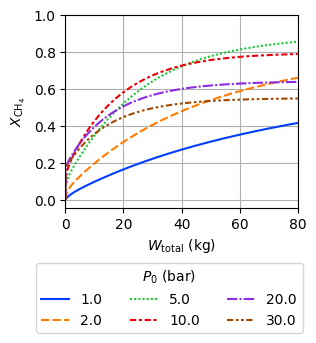

In [83]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$',
             hue='$P_0$ (bar)', 
             palette = 'bright',
             style='$P_0$ (bar)',
             data=reactor_df_P0)

plt.grid(which='both')
plt.ylim(None, 1)
plt.xlim(0, 80)
plt.legend(ncols = 3, title = '$P_0$ (bar)', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_X_CH4_P_effect.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

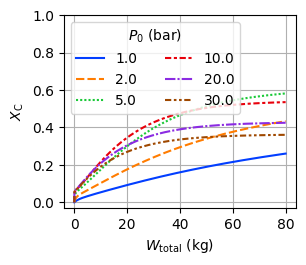

In [84]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_\mathrm{C}$',
             hue='$P_0$ (bar)', 
             palette = 'bright',
             style='$P_0$ (bar)',
             data=reactor_df_P0)

plt.grid(which='both')
plt.ylim(None, 1)
plt.legend(ncols = 2, title = '$P_0$ (bar)')

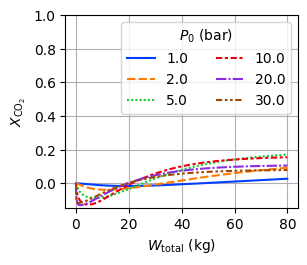

In [85]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CO_2}}$',
             hue='$P_0$ (bar)', 
             palette = 'bright',
             style='$P_0$ (bar)',
             data=reactor_df_P0)
plt.grid(which='both')
plt.ylim(None, 1)
plt.legend(ncols = 2, title = '$P_0$ (bar)')

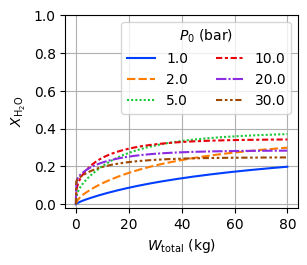

In [86]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{H_2O}}$',
             hue='$P_0$ (bar)', 
             palette = 'bright',
             style='$P_0$ (bar)',
             data=reactor_df_P0)
plt.grid(which='both')
plt.ylim(None, 1)
plt.legend(ncols = 2, title = '$P_0$ (bar)')

In [87]:
reactor_df_P0.columns

Index(['F_H2O_s', 'F_CO2_s', 'F_H2_s', 'F_N2_s', 'F_CH4_s', 'F_CO_s',
       '$T$ (K)', '$P$ (Pa)', '$F_{\mathrm{biogas_0}}$ (mol/s)',
       'biogas feed (kg/day)', '$\dot{m}_{C_{12}H_{26}}$ (kg/dia)',
       '$\eta_{\mathrm{SRM}}$', '$P_{CH_4}$ (Pa)', '$\eta_{\mathrm{WGS}}$',
       '$U~(\mathrm{W~m^{-2}~K^{-1}}$)', '$T_{\mathrm{in}}$ (ºC)', '$T$ (ºC)',
       '$T_{\mathrm{furnace}}$ (ºC)', '$W_{\mathrm{tube}}$ (kg)',
       '$W_{\mathrm{total}}$ (kg)', '$\Delta T_{max}$ (K)', '$T_{min}$ (ºC)',
       '$\mathrm{H_2O/CH_4}$', '$\mathrm{CH_4/CO_2}$', '$D$ (cm)',
       '$D_p$ (cm)', '$D_p$ (mm)', '$P_0$ (bar)', '$\Delta P$ (Pa)',
       '$n_{tubes}$', '$z$ (m)', '$\mathrm{H_2/CO}$',
       '$\mathrm{(H_2/CO)_{out}}$', '$X_{\mathrm{CH_4}}$',
       '$X_{\mathrm{H_2O}}$', '$X_{\mathrm{CO_2}}$', '$X_{\mathrm{CH_4,out}}$',
       '$X_{\mathrm{H_2O,out}}$', '$X_{\mathrm{CO_2,out}}$', '$X_\mathrm{C}$',
       '$X_{\mathrm{C,out}}$', 'Mears criterion'],
      dtype='object')

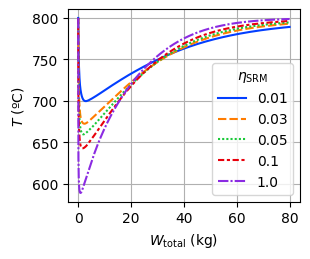

In [88]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = [0.01, 0.03, 0.05, 0.1, 1]
eff_WGS = [0.07]
mass_cat = 80
reactor_df_eff = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y='$T$ (ºC)',
             hue=r'$\eta_{\mathrm{SRM}}$', 
             palette = 'bright',
             style=r'$\eta_{\mathrm{SRM}}$',
             data=reactor_df_eff)

plt.grid(which='both')
# plt.ylim(None, 1)
# plt.legend(ncols = 1, title = '$\Omega$', bbox_to_anchor=(1.05, -0.25))
fig_name = 'figure_W_vs_T_hue_eta.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

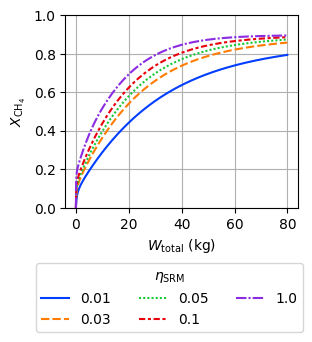

In [89]:
fig, ax = plt.subplots(figsize=(3,2.5))
sns.lineplot(x=r'$W_{\mathrm{total}}$ (kg)', y=r'$X_{\mathrm{CH_4}}$',
             hue=r'$\eta_{\mathrm{SRM}}$', 
             palette = 'bright',
             style=r'$\eta_{\mathrm{SRM}}$',
             data=reactor_df_eff)

plt.grid(which='both')
plt.legend(ncols = 3, title = r'$\eta_{\mathrm{SRM}}$', bbox_to_anchor=(1.05, -0.25))
plt.ylim(0,1)
fig_name = 'figure_W_vs_X_CH4_hue_eta.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')

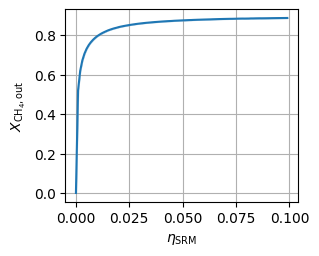

In [90]:
fig, ax = plt.subplots(figsize=(3,2.5))
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5] # Pa
Dp = [0.4]
eff_SRM = np.arange(0, 0.1, 0.001)
mass_cat = 80
reactor_df_eff_X_out = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$\eta_{\mathrm{SRM}}$', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_eff_X_out)

plt.grid(which='both')

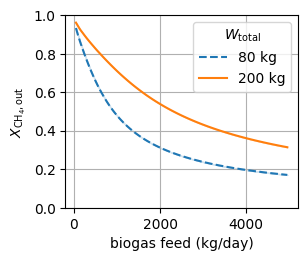

In [91]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [2e5]
Dp = [0.4]
eff_SRM = [0.03]
eff_WGS = [0.07]
mass_cat = 80 # kg
FT0 = np.arange(0.1*0.2128, 10*0.2128, 0.1*0.2128)
reactor_df_FT0_80kg = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, 
                                           CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [2e5]
Dp = [0.4]
eff_SRM = [0.03]
eff_WGS = [0.07]
mass_cat = 200 # kg
FT0 = np.arange(0.1*0.2128, 10*0.2128, 0.1*0.2128)

fig, ax = plt.subplots(figsize=(3,2.5))
reactor_df_FT0_200kg = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, 
                                           CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x='biogas feed (kg/day)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_FT0_80kg, ax = ax, label = '80 kg', linestyle = 'dashed')
sns.lineplot(x='biogas feed (kg/day)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_FT0_200kg, ax = ax, label = '200 kg')
# 
fig_name = 'figure_FT0_vs_X_2bar.pdf'
# plt.ylabel('$(H_2/CO)_{saída}$')
# plt.xlim(0, None)
plt.legend(title = r'$W_{\mathrm{total}}$')
plt.ylim(0, 1)
plt.grid(which='both')
plt.savefig(fig_name, bbox_inches = 'tight')

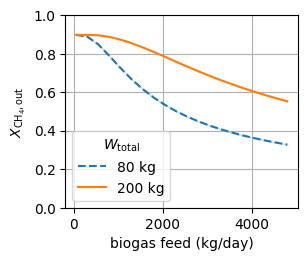

In [92]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5]
Dp = [0.4]
eff_SRM = [0.03]
eff_WGS = [0.07]
mass_cat = 80 # kg
FT0 = np.arange(0.1*0.2128, 10*0.2128, 0.5*0.2128)
reactor_df_FT0_80kg = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, 
                                           CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = [5.6e5]
Dp = [0.4]
eff_SRM = [0.03]
eff_WGS = [0.07]
mass_cat = 200 # kg
FT0 = np.arange(0.1*0.2128, 10*0.2128, 0.5*0.2128)

fig, ax = plt.subplots(figsize=(3,2.5))
reactor_df_FT0_200kg = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, 
                                           CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x='biogas feed (kg/day)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_FT0_80kg, ax = ax, label = '80 kg', linestyle = 'dashed')
sns.lineplot(x='biogas feed (kg/day)', y=r'$X_{\mathrm{CH_4,out}}$',
             data=reactor_df_FT0_200kg, ax = ax, label = '200 kg')
# 
fig_name = 'figure_FT0_vs_X_5bar.pdf'
# plt.ylabel('$(H_2/CO)_{saída}$')
# plt.xlim(0, None)
plt.legend(title = r'$W_{\mathrm{total}}$')
plt.ylim(0, 1)
plt.grid(which='both')
plt.savefig(fig_name, bbox_inches = 'tight')

In [93]:
biogas_m0 = 3000

df_sort = reactor_df_FT0_80kg.iloc[(reactor_df_FT0_80kg['biogas feed (kg/day)']-biogas_m0).abs().argsort()[:2]]
df_sort[['biogas feed (kg/day)', r'$X_{\mathrm{CH_4,out}}$', r'$X_{\mathrm{CO_2,out}}$', r'$X_{\mathrm{C,out}}$']]

,biogas feed (kg/day),"$X_{\mathrm{CH_4,out}}$","$X_{\mathrm{CO_2,out}}$","$X_{\mathrm{C,out}}$"
25967,3050.591846,0.427038,-0.075062,0.226198
25966,3050.591846,0.427038,-0.075062,0.226198


In [94]:
biogas_m0 = 500

df_sort = reactor_df_FT0_80kg.iloc[(reactor_df_FT0_80kg['biogas feed (kg/day)']-biogas_m0).abs().argsort()[:2]]
df_sort[['biogas feed (kg/day)', r'$X_{\mathrm{CH_4,out}}$', r'$X_{\mathrm{CO_2,out}}$', r'$X_{\mathrm{C,out}}$']]

,biogas feed (kg/day),"$X_{\mathrm{CH_4,out}}$","$X_{\mathrm{CO_2,out}}$","$X_{\mathrm{C,out}}$"
4063,550.106726,0.848788,0.167104,0.576114
4062,550.106726,0.848788,0.167104,0.576114


In [95]:
biogas_m0 = 3000

df_sort = reactor_df_FT0_200kg.iloc[(reactor_df_FT0_200kg['biogas feed (kg/day)']-biogas_m0).abs().argsort()[:2]]
df_sort[['biogas feed (kg/day)', r'$X_{\mathrm{CH_4,out}}$', r'$X_{\mathrm{CO_2,out}}$', r'$X_{\mathrm{C,out}}$']]

,biogas feed (kg/day),"$X_{\mathrm{CH_4,out}}$","$X_{\mathrm{CO_2,out}}$","$X_{\mathrm{C,out}}$"
25967,3050.591846,0.685569,0.051664,0.432007
25966,3050.591846,0.685569,0.051664,0.432007


In [96]:
biogas_m0 = 500

df_sort = reactor_df_FT0_200kg.iloc[(reactor_df_FT0_200kg['biogas feed (kg/day)']-biogas_m0).abs().argsort()[:2]]
df_sort[['biogas feed (kg/day)', r'$X_{\mathrm{CH_4,out}}$', r'$X_{\mathrm{CO_2,out}}$', r'$X_{\mathrm{C,out}}$']]

,biogas feed (kg/day),"$X_{\mathrm{CH_4,out}}$","$X_{\mathrm{CO_2,out}}$","$X_{\mathrm{C,out}}$"
4063,550.106726,0.895887,0.197824,0.616662
4062,550.106726,0.895887,0.197824,0.616662


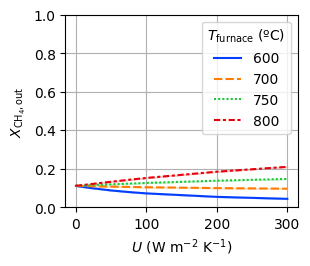

In [97]:
# for the i&ECR paper
fig, ax = plt.subplots(figsize=(3,2.5))
U = [0, 1, 2, 3, 5, 10, 20, 50, 75, 100, 200, 
     300]
T_in_C = [800]
T_furnace = [600, 700, 750, 800]
H2O_CH4 = [2]
CH4_CO2 = [1.5]
D_our = [1] # cm
n_tubes = [60]
P0 = [1e5] # Pa
Dp = [0.1725/10] # cm
eff_SRM = [1]
eff_WGS = [1]
mass_cat = 2/1000 # kg
FT0 = [3.2e-4] # mol/s

reactor_df_U_bench = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)
sns.lineplot(x=r'$U~(\mathrm{W~m^{-2}~K^{-1}}$)', y=r'$X_{\mathrm{CH_4,out}}$', hue=r'$T_{\mathrm{furnace}}$ (ºC)', 
             data=reactor_df_U_bench, 
             ax = ax,
             palette = 'bright',
                style=r'$T_{\mathrm{furnace}}$ (ºC)'
            )

# 
plt.grid(which='both')
plt.ylim(0,1)
fig_name = 'figure_U_effect_on_X_bench_scale.pdf'
# plt.title('(a)')
plt.savefig(fig_name, bbox_inches = 'tight')

In [98]:
cut_off = reactor_df_U_bench.loc[reactor_df_U_bench[r'$X_{\mathrm{CH_4,out}}$'] == 
                       reactor_df_U_bench[r'$X_{\mathrm{CH_4,out}}$'].iloc[-1]][r'$X_{\mathrm{CH_4,out}}$'].mean()*0.9
cut_off

np.float64(0.18837801258850784)

In [99]:
U = [121]
T_in_C = [800]
T_furnace = [800]
H2O_CH4 = [1, 2, 4, 6]
CH4_CO2 = [1.5]
D_our = [4.51] # cm
n_tubes = [60]
P0 = np.arange(1e4, 3.05e6, 5e4) # Pa
Dp = [0.4]
eff_SRM = [0.03]
mass_cat = 200
FT0 = [0.2128] # mol/s
reactor_df_Xc_P_H2O_CH4 = reactor_simulation(U, T_in_C, T_furnace, H2O_CH4, CH4_CO2, D_our, n_tubes, P0, Dp, mass_cat, eff_SRM, eff_WGS, FT0)

U 121 T_in_C 800 T_furnace 800 H2O_CH4 6 CH4_CO2 1.5 D_our 4.51 n_tubes 60 P0 3010000.0 Dp 0.4 W_T 200 eff 0.03 1 FT0 0.2128


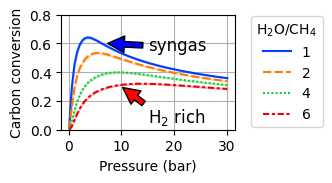

In [100]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(5.7*cm,3.8*cm))

sns.lineplot(x='$P_0$ (bar)', y=r'$X_\mathrm{C}$', hue=r'$\mathrm{H_2O/CH_4}$', 
             data=reactor_df_Xc_P_H2O_CH4, 
                palette = 'bright',
                style=r'$\mathrm{H_2O/CH_4}$', ax = ax)
plt.ylim(0,0.8)
plt.ylabel('Carbon conversion')
plt.xlabel('Pressure (bar)')
plt.grid(which='both')
plt.legend(ncols = 1, title = r'$\mathrm{H_2O/CH_4}$', bbox_to_anchor=(1.05, 1.05))
# Adding annotation on the plot.
ax.annotate(r'$\mathrm{H_2}$ rich', xy=(10, 0.3), xytext=(15, 0.05), fontsize=12,
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('syngas', xy=(7, 0.6), xytext=(15, 0.55), fontsize=12,
            arrowprops=dict(facecolor='blue', shrink=0.05))
fig_name = 'figure_P0_vs_Xc_hue_H2O_CH4.pdf'
plt.savefig(fig_name, bbox_inches = 'tight')